# Supervised Learning - Classification

- Spectra-based feature engineering
- Range of classifciation models incl. CatBoost & Logistic Regression.

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef,make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Training Metadata
metadata_train = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/7. Domain Applications /CA2 - Project Report/data/metadata_train.csv')

# Count number of training signatures
train_signature_count = len(metadata_train)
print('No. of training signatures: ', train_signature_count)

# Define an array of target classifications for later model training & testing
y_train = np.array(list(metadata_train.target.astype(bool)))

# Evaluate the class imbalance
count_undamag = len(metadata_train.loc[(metadata_train['target']==0)])
count_damaged = len(metadata_train.loc[(metadata_train['target']==1)])
print(f'Damaged: {count_damaged} of train_signature_count ({round(100*count_damaged/train_signature_count, 1)}%)')

No. of training signatures:  8712
Damaged: 525 of train_signature_count (6.0%)


In [ ]:
damaged_indices = list(metadata_train.loc[(metadata_train['target']==1)].index)

# Feature Engineering

### Data Compression

Feature engineering here focuses on the calculation of spectra `percentiles - mean` features for every `m=1000` time series chunk.  Essentially, we break the signature into 20 second windows and calculate features for these windows (chunks).

In [ ]:
# Create a function to calculate the mean & percentile features
signature_ids = range(train_signature_count)
def compute_spectra(m = 1000):
    """
    compute mean and percentile - Mean for every chunk of m data
    Args:
      m (int): the chunk size
    Returns: d (dict)
      d['mean']: mean in each chunks
      d['percentile']: percentile - mean
    """
    percentile = (100, 99, 95, 0, 1, 5)
    
    # Compute spectra
    print('Computing spectra...', flush=True)
    
    n = train_signature_count # number of samples
    length = 800000 // m 
    n_spectra = len(percentile)

    # Create arrays to store the mean and precentile spectra data 
    mean_signal = np.zeros((n, length), dtype='float32')
    percentile_spectra = np.zeros((n, length, n_spectra), dtype='float32')

    for signature_id in tqdm(signature_ids):
        # Read in signatures one at a time due to memory constraints
        signature_raw = pq.read_table('/content/drive/MyDrive/_MScDA 2021/7. Domain Applications /CA2 - Project Report/data/train.parquet', columns=[str(signature_id)]).to_pandas().values
        v = signature_raw[:, 0].astype('float32').reshape(-1, m) / 128.0

        mean = np.mean(v, axis=1)        
        s = np.abs(np.percentile(v, percentile, axis=1) - mean)

        # subtract baseline
        h = np.percentile(s, 5.0)
        s = np.maximum(0.0, s - h)

        mean_signal[signature_id, :] = mean
        percentile_spectra[signature_id, :, :] = s.T
            
    d = {}
    d['mean'] = mean_signal
    d['percentile'] = percentile_spectra
    
    return d

spec_train = compute_spectra()
print('done.')

Computing spectra...


  0%|          | 0/8712 [00:00<?, ?it/s]

done.


In [ ]:
compressed_signals = spec_train['mean']

In [ ]:
np.save('compressed_signals', compressed_signals)

### Visualisation of Compressed Data

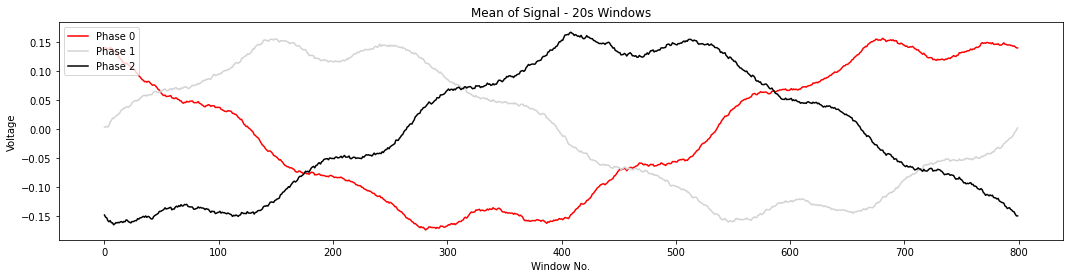

In [ ]:
# Plot the compressed signatures for the 1st signal id (800 chunks & mean of raw signal)
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(spec_train['mean'][0, :], label='Phase 0', color = 'red')
ax.plot(spec_train['mean'][1, :], label='Phase 1', color = 'lightgrey')
ax.plot(spec_train['mean'][2, :], label='Phase 2', color = 'black')
ax.legend(loc = "upper left")
plt.ylabel("Voltage")
plt.xlabel("Window No.") 
plt.title("Mean of Signal - 20s Windows")
plt.show()

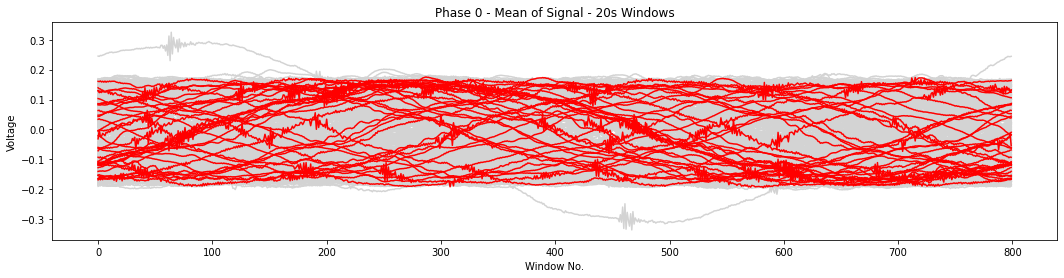

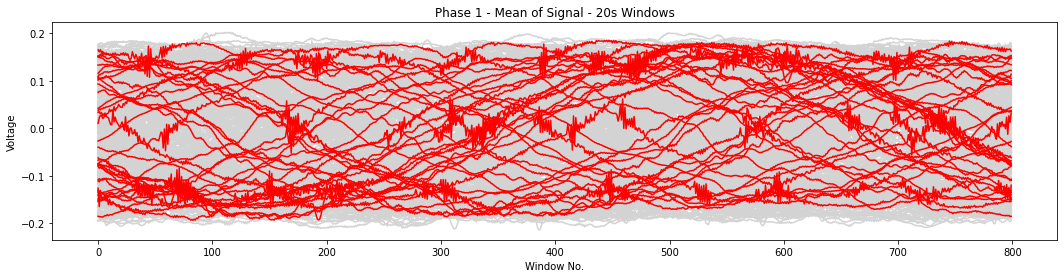

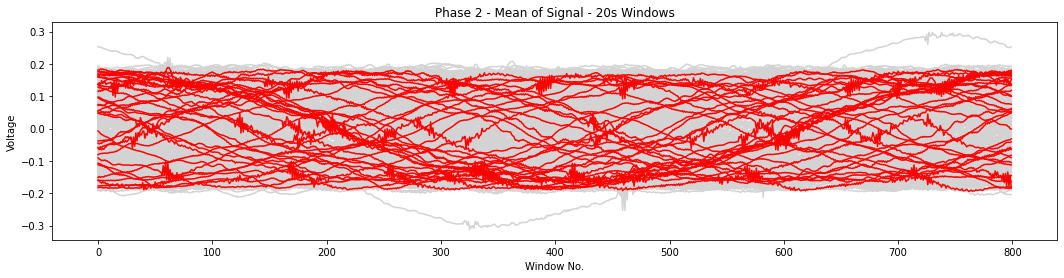

In [ ]:
# Plot 100 compressed Phase 0 signatures
for p in range(3):
    fig, ax = plt.subplots(figsize = (18, 4))
    for j in range(500):
        if j in damaged_indices:
            ax.plot(spec_train['mean'][((p + 1 + j*3) - 1), :], color = 'red', zorder = 2)
        else:
            ax.plot(spec_train['mean'][((p + 1 + j*3) - 1), :], color = 'lightgrey', zorder = 1)
        
    plt.ylabel("Voltage")
    plt.xlabel("Window No.") 
    plt.title(f"Phase {p} - Mean of Signal - 20s Windows")
    plt.show()

**Note** No consistent phasing in each phase.

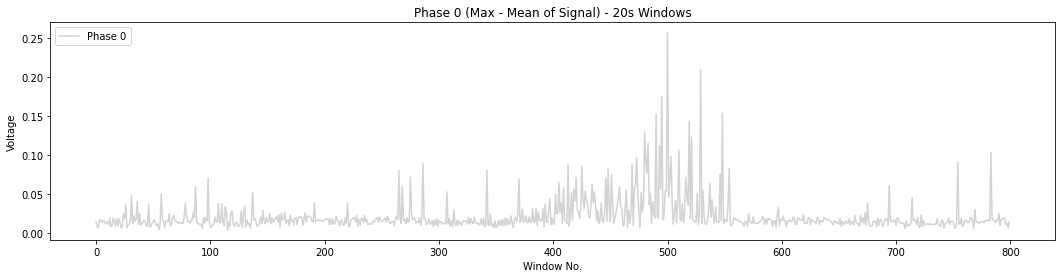

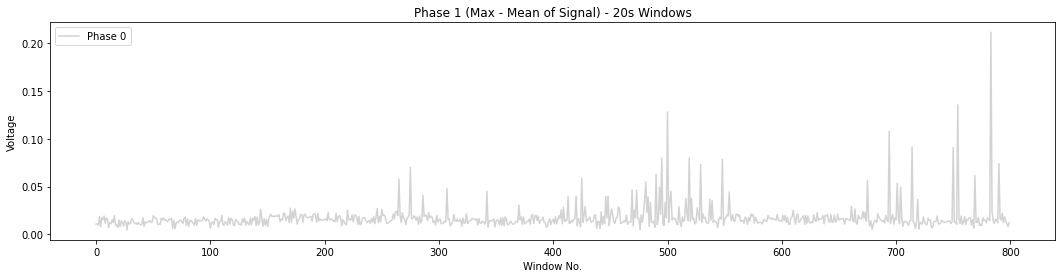

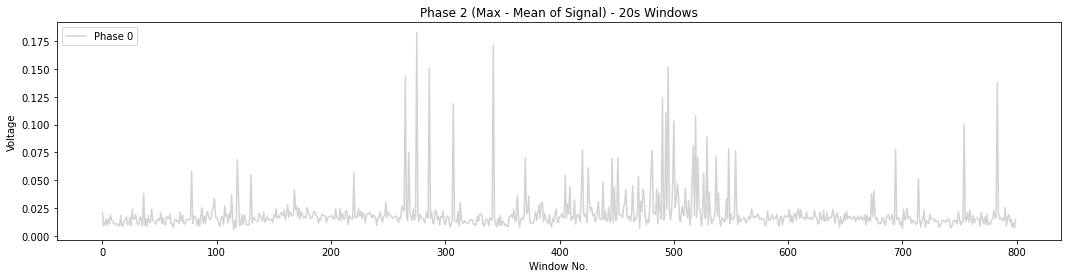

In [ ]:
for p in range(3):
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(spec_train['percentile'][p, :, 0], label='Phase 0', color = 'lightgrey')
    ax.legend(loc = "upper left")
    plt.ylabel("Voltage")
    plt.xlabel("Window No.") 
    plt.title(f"Phase {p} (Max - Mean of Signal) - 20s Windows")
    plt.show()

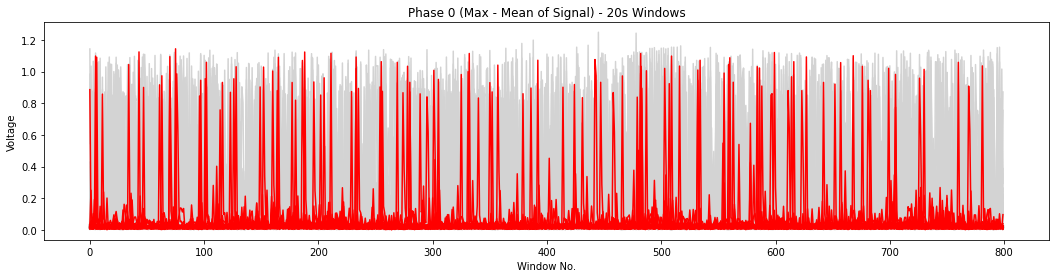

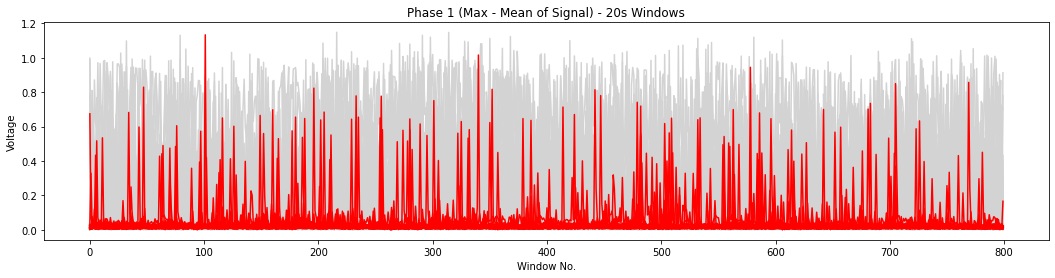

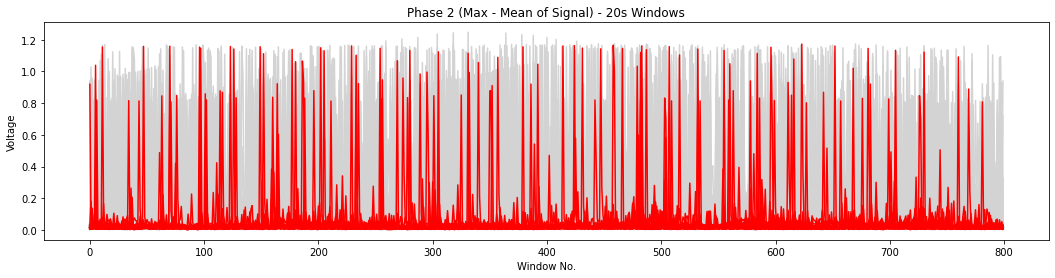

In [ ]:
for p in range(3):
    fig, ax = plt.subplots(figsize = (18, 4))
    for j in range(500):
        if j in damaged_indices:
            ax.plot(spec_train['percentile'][((p + 1 + j*3) - 1), :, 0], label='Phase 0', color = 'red', zorder = 2)
        else:
            ax.plot(spec_train['percentile'][((p + 1 + j*3) - 1), :, 0], label='Phase 0', color = 'lightgrey', zorder = 1)
    plt.ylabel("Voltage")
    plt.xlabel("Window No.") 
    plt.title(f"Phase {p} (Max - Mean of Signal) - 20s Windows")
    plt.show()

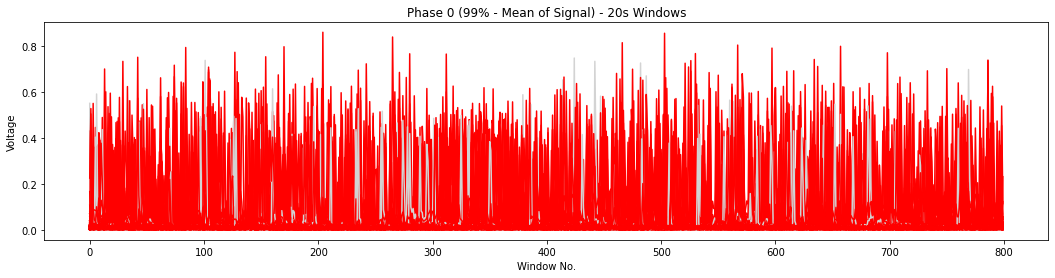

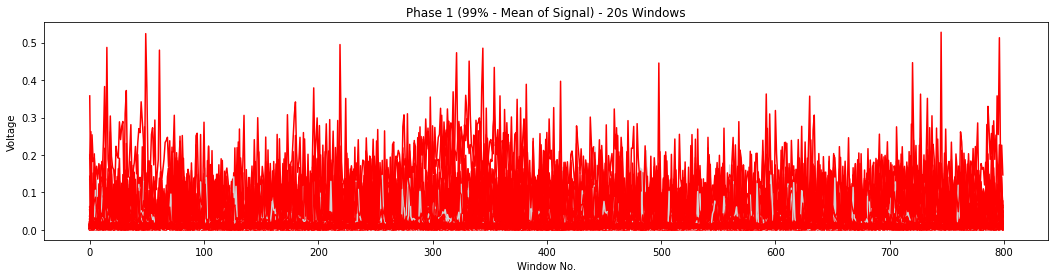

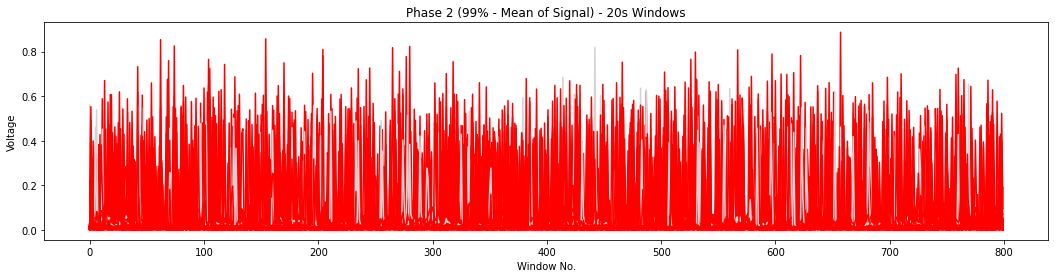

In [ ]:
for p in range(3):
    fig, ax = plt.subplots(figsize = (18, 4))
    for j in range(500):
        if j in damaged_indices:
            ax.plot(spec_train['percentile'][((p + 1 + j*3) - 1), :, 1], label='Phase 0', color = 'lightgrey', zorder = 1)
        else:
            ax.plot(spec_train['percentile'][((p + 1 + j*3) - 1), :, 1], label='Phase 0', color = 'red', zorder = 1)
    plt.ylabel("Voltage")
    plt.xlabel("Window No.") 
    plt.title(f"Phase {p} (99% - Mean of Signal) - 20s Windows")
    plt.show()

## Peak interval

- Examine the 800 windows (chunks) of spectra
- Find the *peak interval* of `width=150` that contains the maximum deviation in the max - mean spectrum.

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def max_windowed(spec, *, width=150, stride=10):
    """
    Smooth the spectrum with a tophat window function and find the
    peak inteval that maximises the smoothed spectrum.
    
    Returns: d(dict)
      d['w'] (array): smoothed max - mean spectrum
      d['ibegin'] (array): the left edge index of the peak interval
    """
    n = spec.shape[0]
    length = spec.shape[1] # 800
    nspec = spec.shape[2] # 6 spectra

    n_triplet = n // 3

    # Reorganize the max spectrum from 8712 data to 2904 triplets with 3 phases
    max_spec3 = np.empty((n_triplet, length, 3))
    for i_triplet in tqdm(range(n_triplet)):
        max_spec3[i_triplet, :, 0] = spec[3*i_triplet, :, 0] # phase 0
        max_spec3[i_triplet, :, 1] = spec[3*i_triplet + 1, :, 0] # phase 1
        max_spec3[i_triplet, :, 2] = spec[3*i_triplet + 2, :, 0] # phase 2

    x = tf.compat.v1.placeholder(tf.float32, [None, length, 3]) # input spectra before smoothing
    
    # 800 -> 80: static convolaution
    # convolution but not CNN, the kernel is static
    # smoothing/convolution kernel
    # tophat window function
    # shape (3, 1) adds up 3 phases to one output
    K = np.ones((width, 3, 1), dtype='float32') / width

    W_conv1 = tf.constant(K)
    h_conv1 = tf.nn.conv1d(x, W_conv1, stride=stride, padding='VALID')
    
    with tf.compat.v1.Session() as sess:
        w = sess.run(h_conv1, feed_dict={x:max_spec3})

    imax = np.argmax(w[:, :, 0], axis=1) # index of maximum smoothed spectrum
    
    d = {}
    d['w'] = w # smoothed max spectrum
    d['ibegin'] = imax*stride
    
    return d

peaks = max_windowed(spec_train['percentile'])
print(len(peaks['w'][0]))
print(peaks['ibegin'][0])

  0%|          | 0/2904 [00:00<?, ?it/s]

66
400


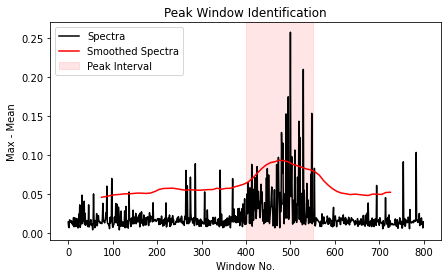

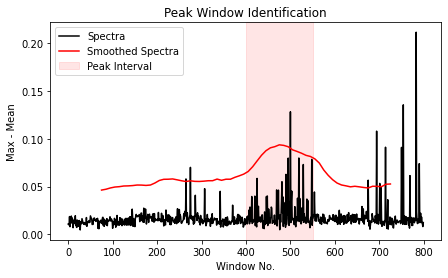

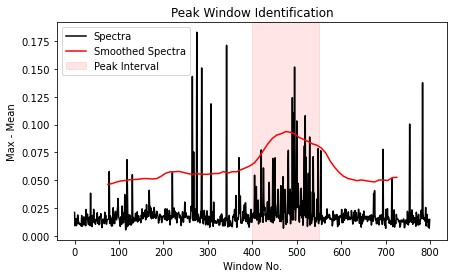

In [ ]:
i_vis = 0
for j in range(3):
    xx = np.arange(peaks['w'].shape[1])*10 + 150//2
    ibegin = peaks['ibegin'][i_vis]
    fig, ax = plt.subplots(figsize = (7, 4))
    plt.axvspan(ibegin, ibegin + 150, alpha=0.1, color='red', label = 'Peak Interval')
    plt.plot(spec_train['percentile'][i_vis + j, :, 0], color='black', label = 'Spectra')
    plt.plot(xx, peaks['w'][i_vis], color='red', label = 'Smoothed Spectra')
    ax.legend(loc = "upper left")
    plt.ylabel("Max - Mean")
    plt.xlabel("Window No.") 
    plt.title("Peak Window Identification")
    plt.show()


**Notes:**
* The *red line* is the smooted `max - mean` spectrum (sum of three phases)
* *Red band* is the `peak interval`, the interval that gives the maximum smoothed line (orange).

Now, compute features in the peak interval.
Mean and Max of `percentile - mean` spectra in the interval.

In [ ]:
def compute_features(spec):
    """
    Args:
      spec (dict): The result of compute_spectra().
    
    Returns:
       X (array): Feature vector of shape (2904, 57)
                  2904 triplets, 57 features
    """
    
    v_spec = spec['percentile']
    shape = v_spec.shape
    n = shape[0] # number of data
    length = shape[1]
    nspec = shape[2]
    
    n_triplet = n // 3
    
    # Reorder to i_triplet, phase
    spec3 = np.empty((n_triplet, length, nspec, 3))
    
    for i_triplet in range(n_triplet):
        spec3[i_triplet, :, :, 0] = v_spec[3*i_triplet, :, :]     # phase 0
        spec3[i_triplet, :, :, 1] = v_spec[3*i_triplet + 1, :, :] # phase 1
        spec3[i_triplet, :, :, 2] = v_spec[3*i_triplet + 2, :, :] # phase 2

    # extract "max-windowed" from the spectra
    width = 150
    peaks = max_windowed(v_spec, width=width)
    
    # Feature vector
    n_feature4 = 3
    X = np.empty((n_triplet, n_feature4*nspec*3 + 3))
    
    # features for each percentile and phase
    X4 = np.empty((n_triplet, n_feature4, nspec, 3)) # triplet, figure, spec type, phase
        
    for i_triplet in range(n_triplet):       
        # Maximum of the spectra in the full range
        # 18 features (6 percentiles x 3 phases)
        X4[i_triplet, 0, :, :] = np.max(spec3[i_triplet, :, :, :], axis=0)
        
        # Peak interval
        ibegin = peaks['ibegin'][i_triplet]
        iend = ibegin + width
        imid = ibegin + width // 2
    
        # Mean of the spectra in the peak inteval 18 features
        X4[i_triplet, 1, :, :] = np.mean(spec3[i_triplet, ibegin:iend, :, :], axis=0)
        
        # Max of the spectra in the peak inteval (18 features)
        X4[i_triplet, 2, :, :] = np.max(spec3[i_triplet, ibegin:iend, :, :], axis=0)
        
        # Mean signal at the midpoint of the interval (3 features)
        X[i_triplet, 0] = spec['mean'][3*i_triplet,     imid]
        X[i_triplet, 1] = spec['mean'][3*i_triplet + 1, imid]
        X[i_triplet, 2] = spec['mean'][3*i_triplet + 2, imid]
    
    shape = X4.shape
    
    # Flatten the X4 tensor
    # 3 + 18x3 = 57 features
    X[:, 3:] = X4.reshape(shape[0], shape[1]*shape[2]*shape[3])
    
    return X

X_all3 = compute_features(spec_train)

# The label for the triple
# True based on majority vote (i.e., 2/3, 3/3)
y_all3 = np.sum(y_train.reshape(-1, 3), axis=1) >= 2

print('Three phases are combined into one training data; the shapes are, therefore,')
print(X_all3.shape, y_all3.shape)

  0%|          | 0/2904 [00:00<?, ?it/s]

Three phases are combined into one training data; the shapes are, therefore,
(2904, 57) (2904,)


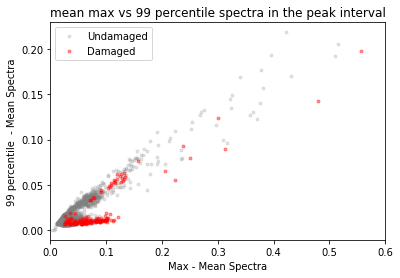

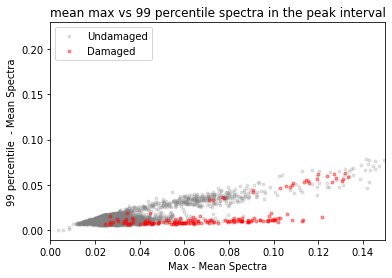

In [ ]:
# 01:03 -- 1:(mean), 2:(mean), 3:(mean) - peak band
# 04:21 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max all
# 22:39 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Mean peak band
# 40:57 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max peak band
j_max = 3 + 18 + 0
j_99 = 3 + 18 + 3
idx_pos = y_all3                 # positive samples
idx_neg = np.logical_not(y_all3) # negative samples
for lim in [0.6, 0.15]:
    fig, ax = plt.subplots(figsize = (6, 4))
    plt.plot(X_all3[idx_neg, j_max], X_all3[idx_neg, j_99], '.', color='gray', alpha = 0.2, label='Undamaged', )
    plt.plot(X_all3[idx_pos, j_max], X_all3[idx_pos, j_99], '.', color='red', alpha = 0.4, label='Damaged')
    plt.title('mean max vs 99 percentile spectra in the peak interval')
    plt.xlim(0, lim)
    plt.legend(loc = "upper left")
    plt.xlabel('Max - Mean Spectra')
    plt.ylabel('99 percentile  - Mean Spectra')
    plt.show()

**Comments on Above Visualisation:**
- Positive samples tends to have small `99% - mean` feature for given `max - mean` feature,

# Training and Cross Validation

1. Split to training and test
2. Apply SMOTE & random under-asampling on training data
3. Perform grid search hyperparameter optimisation  
4. Perform cross validation with training data (5-fold)
5. Select final model
6. Train on all training data
7. Calculate performance measures on test data

### Scale Data

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_all3_scaled = scaler.fit_transform(X_all3)
X_all3_scaled = X_all3

## Class Imbalance Treatment

Counter({False: 2729, True: 175}), Percentage: 6.4%
Train:  Counter({False: 2183, True: 140})
Test:  Counter({False: 546, True: 35})
Counter({False: 2183, True: 140})
Counter({False: 436, True: 218})


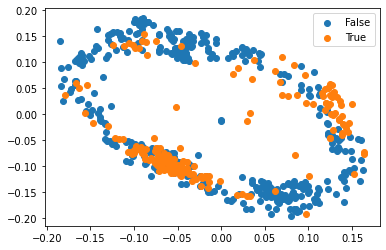

In [ ]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

y_all3.shape
imb_per = round(100*Counter(y_all3)[1]/Counter(y_all3)[0], 1)
print(f'{Counter(y_all3)}, Percentage: {imb_per}%')

# Split the dataset to create a hold-out test set before under and over sampling
X_train, X_test, y_train, y_test = train_test_split(X_all3_scaled, y_all3, test_size=0.20, random_state=0)

print('Train: ', Counter(y_train))
print('Test: ', Counter(y_test))

# Over and Under Sampling of Training Data
X = X_train
y = y_train

# Summarize again the class distribution
counter = Counter(y)
print(counter)

# Increase minority class to 10% of majorty class (not undersampled)
over = SMOTE(sampling_strategy=0.1, random_state=193) #153

# Reduce majority class to 50% more than new minority class count
under = RandomUnderSampler(sampling_strategy=0.5, random_state=583) #183 

# Define pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset using the pipeline
X, y = pipeline.fit_resample(X, y)

# Summarize the new class distribution
counter = Counter(y)
print(counter)

# Scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

## CatBoost Algorithm
CatBoost (created by Yandex in Russia) is one of the latest boosting algorithms (available since 2017). Other boosting algorithms like XGBoost, LightGBM etc. are also good but CatBoost is often considered to be best for Categorical Boosting because it is designed to work with categorical data.

In [ ]:
import sklearn.model_selection
import sklearn.metrics
from catboost import CatBoostClassifier

#### Hyperparameter Tuning

In [ ]:
# Use Randomsearchcv to find good hyperparameters.
params = {'depth': [5, 6, 7, 8, 9],
 'learning_rate' : [0.0001, 0.001, 0.005, 0.01, 0.1],
 'l2_leaf_reg': [2, 4, 6, 8],
 'iterations': [100, 200, 300, 400]}
cb = CatBoostClassifier()
cb_model = RandomizedSearchCV(cb, params, verbose=1, cv=3, n_jobs=-1)
cb_model.fit(X_all3_scaled, y_all3.astype(float), verbose=0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f5e6dcec990>,
                   n_jobs=-1,
                   param_distributions={'depth': [5, 6, 7, 8, 9],
                                        'iterations': [100, 200, 300, 400],
                                        'l2_leaf_reg': [2, 4, 6, 8],
                                        'learning_rate': [0.0001, 0.001, 0.005,
                                                          0.01, 0.1]},
                   verbose=1)

In [ ]:
cb_model.best_estimator_

In [ ]:
cb_model.best_params_

{'depth': 5, 'iterations': 200, 'l2_leaf_reg': 8, 'learning_rate': 0.1}

### CatBoost Model Function

In [ ]:
def run_catboost (X, y):
    # split into train and CV data
    n_splits = 5
    splits = list(sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019).split(X, y))

    models = []
    scores = np.zeros(n_splits)

    print('Training...')

    for i, (idx_train, idx_cv) in enumerate(splits):
        print(f'\nCV Split {i+1} Confusion Matrix:')
        X_train = X[idx_train, :]
        y_train = y[idx_train]

        X_cv = X[idx_cv, :]
        y_cv = y[idx_cv]

        # Learning rate is important; large values overfit the data
        model = CatBoostClassifier(learning_rate=0.01, depth=8, l2_leaf_reg=8, od_type='IncToDec',
                                loss_function='Logloss', use_best_model=True, eval_metric='MCC')

        model.fit(X_train, y_train.astype(float), silent=True,
                  eval_set=(X_cv, y_cv.astype(float)))

        y_predict_train = model.predict(X_train)
        y_predict_cv = model.predict(X_cv)

        score_train = sklearn.metrics.matthews_corrcoef(y_train, y_predict_train)
        score_cv = sklearn.metrics.matthews_corrcoef(y_cv, y_predict_cv)

        models.append(model)
        scores[i] = score_cv

        print(sklearn.metrics.confusion_matrix(y_cv, y_predict_cv))
        print('\nRecall: ', round(sklearn.metrics.recall_score(y_cv, y_predict_cv), 2))
        print('Precision: ', round(sklearn.metrics.precision_score(y_cv, y_predict_cv), 2))

        #print('%d %.3f %.3f' % (i, score_train, score_cv))
    
    return(model)
    print('\nCV MCC scores %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

#### Model Training & Cross Validation

In [ ]:
# Train the CatBoost Model on the SMOTE data
smote_model = run_catboost(X=X, y=y)

Training...

CV Split 1 Confusion Matrix:
[[88  0]
 [ 6 37]]

Recall:  0.86
Precision:  1.0

CV Split 2 Confusion Matrix:
[[86  1]
 [ 3 41]]

Recall:  0.93
Precision:  0.98

CV Split 3 Confusion Matrix:
[[84  3]
 [ 3 41]]

Recall:  0.93
Precision:  0.93

CV Split 4 Confusion Matrix:
[[84  3]
 [ 7 37]]

Recall:  0.84
Precision:  0.92

CV Split 5 Confusion Matrix:
[[83  4]
 [ 3 40]]

Recall:  0.93
Precision:  0.91


#### Model Testing (Hold-out Data)

In [ ]:
y_predict_test = smote_model.predict(X_test)
print(Counter(y_test), '\n')
conf_mat_cb = sklearn.metrics.confusion_matrix(y_test, y_predict_test)
false_alarms = round(100*conf_mat_cb[0, 1] / conf_mat_cb[0, 0], 1)
print(conf_mat_cb)
print('\nRecall: ', round(sklearn.metrics.recall_score(y_test, y_predict_test), 2))
print('Precision: ', round(sklearn.metrics.precision_score(y_test, y_predict_test), 2))
print('F beta: ', round(sklearn.metrics.fbeta_score(y_test, y_predict_test, beta=2), 2))
print(f'False Alarms: {false_alarms}%')

Counter({False: 546, True: 35}) 

[[522  24]
 [ 12  23]]

Recall:  0.66
Precision:  0.49
F beta:  0.61
False Alarms: 4.6%


## Standard Gradient Boosted Classifier from Scikit Learn

In [ ]:
# Evaluate generic gradient boosting algorithm for classification
import sklearn.metrics
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import fbeta_score, make_scorer

In [ ]:
# Try Randomsearchcv to find good hyperparameters.
params = {'max_depth': [3, 5, 6, 7, 8, 9],
 'learning_rate' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1],
 'subsample': [0.8, 0.9, 1.0],
 'n_estimators': [50, 100, 200, 300, 400, 450, 500]}
gb = GradientBoostingClassifier()
gb_model = RandomizedSearchCV(gb, params, verbose=1, cv=3, n_jobs=-1, n_iter=20)
gb_model.fit(X, y.astype(float))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.005,
                                                          0.01, 0.05, 0.1, 1],
                                        'max_depth': [3, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         450, 500],
                                        'subsample': [0.8, 0.9, 1.0]},
                   verbose=1)

In [ ]:
gb_model.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 450, 'subsample': 0.9}

In [ ]:
# Try grid search (check every parameter)
from sklearn.model_selection import GridSearchCV
params = {'max_depth': [3, 5, 6, 7, 8, 9],
 'learning_rate' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1],
 'subsample': [0.8, 0.9, 1.0],
 'n_estimators': [50, 100, 200, 300, 400, 450, 500]}
gb = GradientBoostingClassifier()
gb_model = GridSearchCV(gb, params, verbose=1, cv=3, n_jobs=-1)
gb_model.fit(X, y)

Fitting 3 folds for each of 882 candidates, totalling 2646 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.05,
                                           0.1, 1],
                         'max_depth': [3, 5, 6, 7, 8, 9],
                         'n_estimators': [50, 100, 200, 300, 400, 450, 500],
                         'subsample': [0.8, 0.9, 1.0]},
             verbose=1)

In [ ]:
gb_model.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}

In [ ]:
# Define and train the model
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=9, subsample=0.8, random_state=0)

# Define the evaluation method (use stratified K fold - 5 splits)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Define F-measure with Beta = 2 & evaluate the model on the dataset
ftwo_scorer = make_scorer(fbeta_score, beta=2)
n_scores = cross_val_score(model, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1)

# Report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.890 (0.031)


In [ ]:
# Fit the model on the complete training data
model.fit(X, y)

y_predict_test = model.predict(X_test)
print(Counter(y_test), '\n')

conf_mat_cb = sklearn.metrics.confusion_matrix(y_test, y_predict_test)
false_alarms = round(100*conf_mat_cb[0, 1] / (conf_mat_cb[0, 0] + conf_mat_cb[0, 1]), 1)

print(conf_mat_cb)
print('\nRecall: ', round(sklearn.metrics.recall_score(y_test, y_predict_test), 2))
print('Precision: ', round(sklearn.metrics.precision_score(y_test, y_predict_test), 2))
print('F2 measure: ', round(sklearn.metrics.fbeta_score(y_test, y_predict_test, beta=2), 2))
print(f'False Alarms: {false_alarms}%')

Counter({False: 546, True: 35}) 

[[521  25]
 [ 10  25]]

Recall:  0.71
Precision:  0.5
F2 measure:  0.66
False Alarms: 4.6%


## Feature Importance using MDI & Permutation-based Methods

In [ ]:
feature_names = [f"feature {i}" for i in range(1, X.shape[1]+1, 1)]
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)

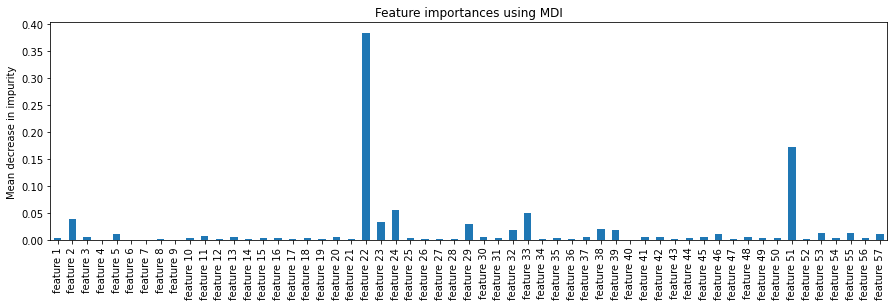

In [ ]:
gb_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize = (15, 4))
gb_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()
# 01:03 -- 1:(mean), 2:(mean), 3:(mean) - peak band
# 04:21 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max all
# 22:39 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Mean peak band
# 40:57 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max peak band

#### Permutation Feature Importance
https://www.kaggle.com/code/dansbecker/permutation-importance/tutorial

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=55, n_jobs=-1)
gb_importances = pd.Series(result.importances_mean, index=feature_names)

In [ ]:
gb_importances = gb_importances.sort_values(ascending=False)

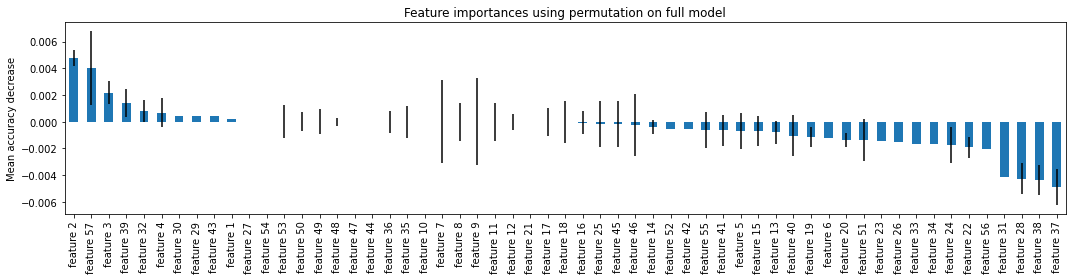

In [ ]:
fig, ax = plt.subplots(figsize = (15, 4))
gb_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
# 01:03 -- 1:(mean), 2:(mean), 3:(mean) - peak band
# 04:21 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max all
# 22:39 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Mean peak band
# 40:57 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max peak band

## Feature Value using SHAP

In [ ]:
!pip install shap
import shap
# print the JS visualization code to the notebook
shap.initjs()

     |████████████████████████████████| 564 kB 8.7 MB/s 


In [ ]:
# The tree based machine learning model that we want to explain. 
# XGBoost, LightGBM, CatBoost, Pyspark and most tree-based scikit-learn models are supported.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X = pd.DataFrame.from_records(X))

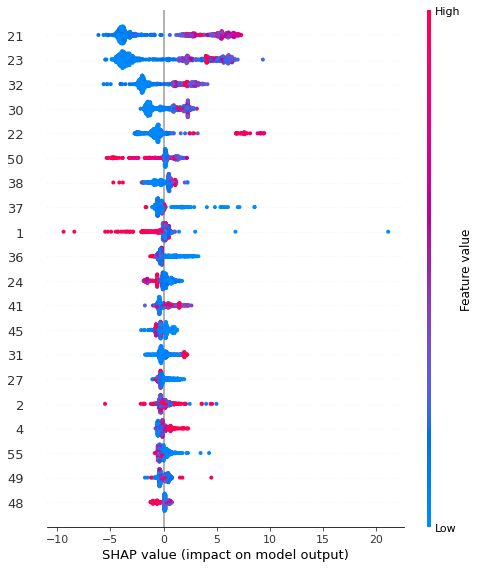

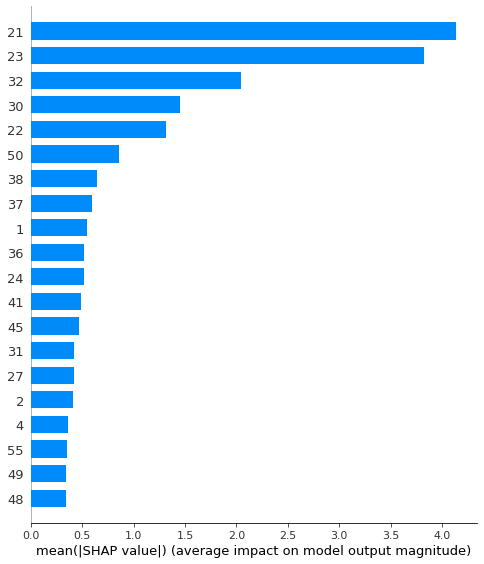

In [ ]:
# Create a visualisation of parameters that are driving model predictions
# Red will be increasing output
# Blue will be decreasing output
shap.initjs()
shap.summary_plot(shap_values = shap_values, features = pd.DataFrame.from_records(X)) 
print('\n')
shap.summary_plot(shap_values = shap_values, features = pd.DataFrame.from_records(X), plot_type='bar') 
# 01:03 -- 1:(mean), 2:(mean), 3:(mean) - peak band
# 04:21 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max all
# 22:39 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Mean peak band
# 40:57 -- 1:(100, 99, 95, 0, 1, 5), 2:(100, 99, 95, 0, 1, 5), 3:(100, 99, 95, 0, 1, 5) - Max peak band

## Logistic Regression

In [ ]:
# split into train and CV data
n_splits = 5
splits = list(sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True).split(X_all3_scaled, y_all3))

models = []
scores = np.zeros(n_splits)

print('Training...')
print('MCC training & cv') # MCC = Matthews Correlation Coefficient

alphas = [10**i for i in range(0, 5)]
cv_mccs = []

# Vary C as alpha
# C is a positive floating-point number (1.0 by default) that defines the relative strength of regularization. 
# Smaller values indicate stronger regularization.
for alpha in alphas:
    print('for alpha = {}'.format(alpha))
    for i, (idx_train, idx_cv) in enumerate(splits):

        #train and cv split
        X_train = X_all3_scaled[idx_train, :]
        y_train = y_all3[idx_train]

        X_cv = X_all3_scaled[idx_cv, :]
        y_cv = y_all3[idx_cv]

        #initalizing and fitting the model
        model = LogisticRegression(C=alpha,max_iter=8000)
        model.fit(X_train, y_train.astype(float))

        #prediction
        y_predict_train = model.predict(X_train)
        y_predict_cv = model.predict(X_cv)
        
        #calculating mcc metric
        score_train = matthews_corrcoef(y_train, y_predict_train)
        score_cv = matthews_corrcoef(y_cv, y_predict_cv)

        #storing the models
        models.append(model)
        scores[i] = score_cv
        
        print(sklearn.metrics.confusion_matrix(y_cv, y_predict_cv))
        print('Recall: ', round(sklearn.metrics.recall_score(y_cv, y_predict_cv), 2))
        print('Precision: ', round(sklearn.metrics.precision_score(y_cv, y_predict_cv), 2))
        
        #printing the train and cross validation mcc score
        print('%d %.3f %.3f' % (i, score_train, score_cv))

    # average of all the scores
    print('\nCV MCC scores %.3f ± %.3f' % (np.mean(scores), np.std(scores)))
    cv_mccs.append(np.mean(scores))
    print()

Training...
MCC training & cv
for alpha = 1
[[544   2]
 [ 33   2]]
Recall:  0.06
Precision:  0.5
0 0.081 0.154
[[546   0]
 [ 31   4]]
Recall:  0.11
Precision:  1.0
1 0.042 0.329
[[542   4]
 [ 35   0]]
Recall:  0.0
Precision:  0.0
2 0.162 -0.021
[[544   2]
 [ 34   1]]
Recall:  0.03
Precision:  0.33
3 0.101 0.083
[[541   4]
 [ 35   0]]
Recall:  0.0
Precision:  0.0
4 0.122 -0.021

CV MCC scores 0.105 ± 0.130

for alpha = 10
[[542   4]
 [ 26   9]]
Recall:  0.26
Precision:  0.69
0 0.383 0.402
[[543   3]
 [ 27   8]]
Recall:  0.23
Precision:  0.73
1 0.341 0.389
[[541   5]
 [ 31   4]]
Recall:  0.11
Precision:  0.44
2 0.391 0.203
[[542   4]
 [ 29   6]]
Recall:  0.17
Precision:  0.6
3 0.458 0.300
[[540   5]
 [ 24  11]]
Recall:  0.31
Precision:  0.69
4 0.366 0.444

CV MCC scores 0.348 ± 0.086

for alpha = 100
[[541   5]
 [ 19  16]]
Recall:  0.46
Precision:  0.76
0 0.640 0.571
[[545   1]
 [ 17  18]]
Recall:  0.51
Precision:  0.95
1 0.639 0.686
[[540   6]
 [ 22  13]]
Recall:  0.37
Precision:  0.68
